In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from IPython.display import clear_output
import time

images = np.load('./images.npy')
labels = np.load('./labels.npy')
num_images,height,width = np.shape(images)
images = images.astype(float)
images = np.reshape(images,(num_images,height*width))/255.0


labels = labels.astype(int)



x_valid = images[45000:50000][:]

y_valid = labels[45000:50000]


x_train = images[0:45000][:]
y_train = labels[0:45000]



train_seqs = x_train
train_labels = y_train

val_seqs = x_valid
val_labels = y_valid


#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 10000
batch_size = 300;


In [74]:
#linear model
class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(HEIGHT*WIDTH, 100)
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50, 5)
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

In [75]:
model = TwoLayerNN()

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [77]:
def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [78]:
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

In [79]:
def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

In [80]:
def accuracy(y,y_hat):
    correct = np.count_nonzero(y_hat.data.numpy()==y.data.numpy())
    return correct/y.data.shape[0]

In [81]:
t = time.time()

train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))

elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 20.70 22.68
   100 78.10 78.76
   200 78.30 80.08
   300 81.80 81.80
   400 83.90 83.02
   500 83.50 83.90
   600 83.90 84.70
   700 84.40 85.40
   800 87.10 85.82
   900 88.00 85.78
  1000 88.40 85.94
  1100 86.90 86.14
  1200 87.60 86.00
  1300 89.10 86.82
  1400 90.20 86.68
  1500 90.10 86.30
  1600 91.80 86.58
  1700 91.30 86.74
  1800 92.60 86.84
  1900 90.40 86.46
  2000 92.30 86.36
  2100 91.90 86.34
  2200 92.60 86.56
  2300 92.90 86.44
  2400 94.60 86.86
  2500 93.40 86.82
  2600 93.70 86.34
  2700 94.30 86.74
  2800 92.20 85.84
  2900 94.70 86.90
  3000 94.90 86.38
  3100 95.20 86.70
  3200 95.40 86.24
  3300 95.60 86.42
  3400 95.60 85.80
  3500 96.30 86.06
  3600 95.60 86.50
  3700 96.30 86.42
  3800 95.70 85.40
  3900 96.70 86.26
  4000 96.10 85.82
  4100 96.20 86.30
  4200 97.60 85.98
  4300 96.80 86.22
  4400 97.60 85.88
  4500 98.10 85.74
  4600 97.90 85.76
  4700 97.40 85.66
  4800 97.70 86.08
  4900 97.60 85.30
  5000 97.80 85.56
  5100 97.70 85.70
  5200 98.20

average accuracy =  0.94902


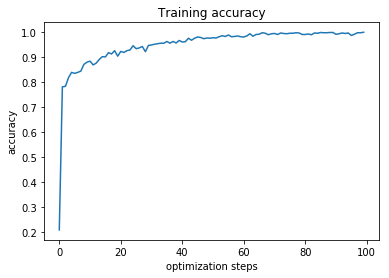

In [82]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.848058


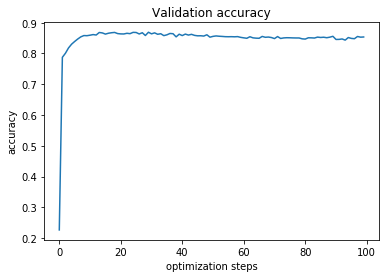

In [83]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [84]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 1.0 for 10000 optimization steps
Max validation accuracy= 0.869 for 10000 optimization steps
batch_size= 300
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 107.65202283859253 secs


In [86]:
#model with 4 hidden layers
for m in model.children():
    m.reset_parameters()
    
#linear model
class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(HEIGHT*WIDTH, 100)
        self.linear2 = torch.nn.Linear(100,75)
        self.linear3 = torch.nn.Linear(75, 50)
        self.linear4 = torch.nn.Linear(50,5)
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

model = TwoLayerNN()

#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 10000
batch_size = 300

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 30.90 31.46
   100 75.40 75.88
   200 78.10 79.06
   300 80.70 79.90
   400 81.10 81.88
   500 82.90 83.28
   600 84.40 83.50
   700 86.10 84.30
   800 86.00 85.00
   900 88.20 85.34
  1000 86.40 86.18
  1100 88.70 85.92
  1200 88.90 85.98
  1300 89.00 86.62
  1400 91.50 86.52
  1500 91.30 86.40
  1600 93.20 86.62
  1700 89.80 86.20
  1800 89.90 86.26
  1900 92.00 86.84
  2000 92.10 86.92
  2100 90.40 86.80
  2200 92.70 86.74
  2300 93.00 86.76
  2400 93.80 86.00
  2500 93.10 86.82
  2600 93.40 86.14
  2700 94.00 86.32
  2800 95.00 85.84
  2900 93.60 86.06
  3000 94.60 86.18
  3100 93.10 86.18
  3200 94.90 85.80
  3300 94.80 86.58
  3400 96.00 85.86
  3500 96.50 85.66
  3600 96.20 86.14
  3700 96.50 86.02
  3800 96.90 86.12
  3900 96.90 85.82
  4000 96.80 85.86
  4100 96.70 86.02
  4200 96.60 85.90
  4300 97.30 85.06
  4400 97.70 85.46
  4500 98.50 85.56
  4600 96.80 85.22
  4700 97.80 85.48
  4800 97.50 85.72
  4900 97.00 85.86
  5000 96.70 85.16
  5100 98.10 85.44
  5200 97.20

average accuracy =  0.94775


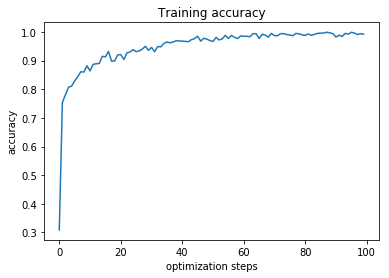

In [87]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.84867


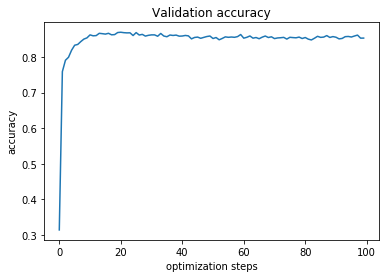

In [88]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [89]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.999 for 10000 optimization steps
Max validation accuracy= 0.8692 for 10000 optimization steps
batch_size= 300
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 108.05133700370789 secs


In [109]:
#with dropout
class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(HEIGHT*WIDTH, 100)
        self.linear2 = torch.nn.Linear(100,75)
        self.linear3 = torch.nn.Linear(75, 50)
        self.linear4 = torch.nn.Linear(50,5)
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        m = torch.nn.Dropout(p=0.2)
        x = m(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = m(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x
    def eval(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

model = TwoLayerNN()
    
def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model.forward(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)

def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)


for m in model.children():
    m.reset_parameters()

model = TwoLayerNN()

#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 5000
batch_size = 128

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 22.00 19.66
   100 74.90 75.78
   200 76.20 78.34
   300 80.40 79.98
   400 80.60 81.16
   500 80.70 81.30
   600 83.00 83.24
   700 84.70 83.54
   800 84.50 83.98
   900 86.80 84.02
  1000 84.70 84.92
  1100 88.30 85.24
  1200 86.40 85.38
  1300 87.60 85.68
  1400 86.90 85.88
  1500 88.40 85.96
  1600 86.80 86.22
  1700 87.80 86.44
  1800 88.60 86.50
  1900 87.30 86.52
  2000 89.60 86.82
  2100 88.60 86.48
  2200 88.70 86.80
  2300 89.50 86.74
  2400 86.80 86.14
  2500 89.50 86.88
  2600 87.90 86.46
  2700 91.30 87.14
  2800 89.30 86.86
  2900 90.90 86.92
  3000 91.70 86.80
  3100 91.90 86.66
  3200 89.70 87.38
  3300 90.90 87.28
  3400 90.70 87.18
  3500 90.20 87.00
  3600 90.50 87.00
  3700 90.50 87.48
  3800 92.10 86.82
  3900 92.20 86.96
  4000 91.30 87.18
  4100 93.20 87.28
  4200 91.40 87.34
  4300 91.10 87.50
  4400 91.90 87.18
  4500 92.50 87.08
  4600 92.10 87.22
  4700 91.70 86.64
  4800 93.30 87.22
  4900 91.20 87.34
Total training time approx. = 43.39731693267822 se

average accuracy =  0.86976


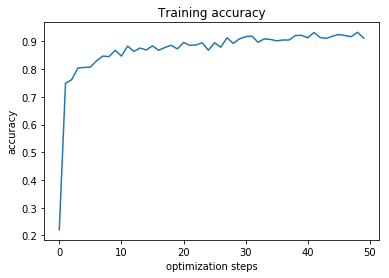

In [110]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.843904


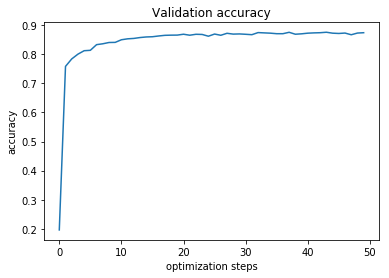

In [111]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [112]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.933 for 5000 optimization steps
Max validation accuracy= 0.875 for 5000 optimization steps
batch_size= 128
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 43.39731693267822 secs


In [107]:
#optimize performance
class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(HEIGHT*WIDTH, 100)
        self.linear2 = torch.nn.Linear(100,75)
        self.linear3 = torch.nn.Linear(75, 50)
        self.linear4 = torch.nn.Linear(50,5)
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        m = torch.nn.Dropout(p=0.2)
        x = m(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x
    def eval(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

model = TwoLayerNN()
    
def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model.forward(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)

def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
model = TwoLayerNN()

#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 5000
batch_size = 300

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 30.30 34.26
   100 77.90 77.34
   200 79.60 79.50
   300 80.30 81.86
   400 82.80 83.64
   500 85.30 84.24
   600 86.20 84.84
   700 85.60 85.34
   800 86.90 86.04
   900 87.70 86.08
  1000 88.00 86.42
  1100 89.00 86.70
  1200 89.20 86.34
  1300 89.50 86.66
  1400 90.00 86.18
  1500 91.50 86.80
  1600 91.90 86.80
  1700 90.30 87.14
  1800 91.60 86.90
  1900 90.50 87.58
  2000 91.90 86.90
  2100 90.60 87.22
  2200 92.40 87.18
  2300 94.10 87.50
  2400 92.10 86.98
  2500 92.70 87.54
  2600 93.30 86.90
  2700 94.60 87.30
  2800 94.90 87.44
  2900 94.50 87.06
  3000 92.50 87.18
  3100 94.20 87.82
  3200 93.50 87.58
  3300 94.70 87.38
  3400 93.90 87.40
  3500 96.70 87.38
  3600 94.90 87.32
  3700 94.60 87.40
  3800 95.00 87.80
  3900 95.40 87.60
  4000 95.60 87.06
  4100 95.80 87.82
  4200 95.40 87.04
  4300 95.40 87.50
  4400 95.60 87.38
  4500 95.50 87.40
  4600 96.50 87.36
  4700 96.30 87.18
  4800 96.70 87.54
  4900 95.40 87.22
Total training time approx. = 66.4208619594574 sec

average accuracy =  0.86976


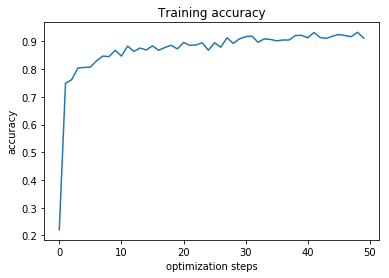

In [113]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.843904


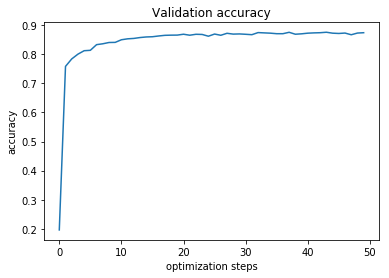

In [114]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [115]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.933 for 5000 optimization steps
Max validation accuracy= 0.875 for 5000 optimization steps
batch_size= 128
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 43.39731693267822 secs


Best validation accuracy 87.5%. 4 layer deep neural net with 5000 optimization steps, Adam optimizer, learning rate of 1e-3, dropout after first layer and second and third layer with p=0.2

Deep neural net used:
3 hidden linear layers with relu activations in each hidden layer and one final linear layer
